In [2]:
from __future__ import absolute_import, division, print_function

#@title Imports and defaults
%matplotlib inline

import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import sys

sys.path.append("..")

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 7
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

print("matplotlib %s" % mpl.__version__)

from bandits.simulator import *
from bandits.algorithms import *
from bandits.phe import *
from bandits.dropout import *
from bandits.hse import *

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)

matplotlib 3.0.2


 32: 0.04 0.99 |  19: 0.06 0.98 |  34: 0.07 0.98 |  45: 0.02 0.94 |  40: 0.13 0.96 |  43: 0.04 0.96 |  39: 0.03 0.85 |  11: 0.08 0.98 |  16: 0.02 0.91 |  16: 0.03 0.99 | 
 43: 0.09 0.99 |  32: 0.05 0.88 |   3: 0.07 0.96 |  37: 0.01 0.95 |  13: 0.02 0.89 |  47: 0.01 0.98 |  15: 0.10 0.87 |   1: 0.06 0.96 |  27: 0.08 0.98 |  17: 0.04 0.94 | 
Evaluating Lin All History-Swapping.................... 2.8 seconds
Regret: 453.70 +/- 98.25 (median: 404.00, max: 1549.00, min: 20.00)
Evaluating Lin All History-Swapping.................... 59.0 seconds
Regret: 341.25 +/- 83.23 (median: 112.00, max: 1182.00, min: 25.00)
Evaluating Lin All History-Swapping.................... 55.6 seconds
Regret: 328.70 +/- 74.56 (median: 217.00, max: 1100.00, min: 19.00)
Evaluating Lin All History-Swapping.................... 55.9 seconds
Regret: 187.95 +/- 51.87 (median: 37.50, max: 835.00, min: 27.00)
Evaluating Lin All History-Swapping.................... 62.9 seconds
Regret: 42.05 +/- 2.08 (median: 41.50, max: 

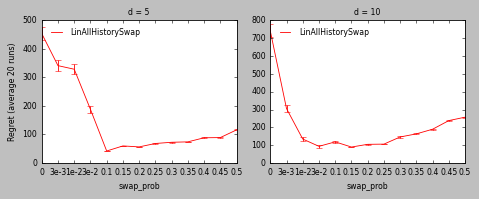

In [3]:
import datetime

reward_noise = "bernoulli"

swap_probs = [0, 3e-3, 1e-2, 3e-2, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
swap_probs_labels = ['0', '3e-3', '1e-2', '3e-2', '0.1', '0.15', '0.2', '0.25', 
                     '0.3', '0.35', '0.4', '0.45', '0.5'] 

x_axis = np.arange(len(swap_probs))
num_runs = 20
n = 10000
K = 50

plt.figure(figsize=(6, 2.5))
algs = ['LinHistorySwap']#, 'LinFreshHistorySwap']
colors = {'LinHistorySwap':'red'}#, 'LinFreshHistorySwap':'blue'}

for fig in range(2):
  if fig == 0:
    d = 5
  elif fig == 1:
    d = 10
  else:
    d = 20
    
  env = []
  for run in range(num_runs):
    # standard d-dimensional basis (with a bias term)
    basis = np.eye(d)
    basis[:, -1] = 1

    # arm features in a unit (d - 2)-sphere
    X = np.random.randn(K, d - 1)
    X /= np.sqrt(np.square(X).sum(axis=1))[:, np.newaxis]
    X = np.hstack((X, np.ones((K, 1))))  # bias term
    X[: basis.shape[0], :] = basis

    # parameter vector in a (d - 2)-sphere with radius 0.5
    theta = np.random.randn(d - 1)
    theta *= 0.5 / np.sqrt(np.square(theta).sum())
    theta = np.append(theta, [0.5])

    # create environment
    env.append(LinBandit(X, theta, reward_noise))
    print("%3d: %.2f %.2f | " % (env[-1].best_arm,
      env[-1].mu.min(), env[-1].mu.max()), end="")
    if (run + 1) % 10 == 0:
      print()

  plt.subplot(1, 2, fig + 1)

  for alg in algs:
    alg_class = eval(alg)
    regret_means = []
    regret_vars = []
    for swap_prob in swap_probs:
        if swap_prob > 0.1 and alg == 'LinFreshHistorySwap':
            regret_means.append(0)
            regret_vars.append(0)
            continue
        
        if d < 14:
            regret, _ = evaluate_parallel(alg_class, 
                {"swap_prob": swap_prob, "swap_top": -1}, env, n, num_process=12)
        else:
            regret, _ = evaluate(alg_class, 
                {"swap_prob": swap_prob, "swap_top": -1}, env, n)

        cum_regret = regret.sum(axis=0)
        regret_means.append(cum_regret.mean())
        regret_vars.append(cum_regret.std()/num_runs)
        
    plt.plot(x_axis, regret_means, colors[alg], dashes=linestyle2dashes('-'), label=alg)
    plt.errorbar(x_axis, regret_means, regret_vars, fmt="none", ecolor=colors[alg])
    plt.xticks(x_axis, swap_probs_labels)
    
  plt.title("d = %d" % d)
  plt.xlabel("swap_prob")
  if not fig:
    plt.ylabel("Regret (average {} runs)".format(num_runs))
  if fig <= 2:
    plt.legend(loc="upper left", frameon=False)  

plt.tight_layout()
now = datetime.datetime.now()
with open("../results/LinHS_vs_SwapProb_{}_{}_{}_{}.jpeg" \
          .format(now.month, now.day, now.hour, now.minute), "wb") as f:
  plt.savefig(f, format="jpeg", dpi=1200, bbox_inches=0)
plt.show()

 41: 0.07 0.95 |  17: 0.09 0.93 | Evaluating LinTS.. 0.6 seconds
Regret: 30.50 +/- 3.18 (median: 30.50, max: 35.00, min: 26.00)
Evaluating LinPHE.. 0.4 seconds
Regret: 52.00 +/- 8.49 (median: 52.00, max: 64.00, min: 40.00)
Evaluating LinPHE.. 0.2 seconds
Regret: 54.50 +/- 6.72 (median: 54.50, max: 64.00, min: 45.00)
Evaluating Lin History-Swapping.. 3.2 seconds
Regret: 36.00 +/- 5.66 (median: 36.00, max: 44.00, min: 28.00)
Evaluating Lin History-Swapping.. 1.6 seconds
Regret: 39.00 +/- 2.83 (median: 39.00, max: 43.00, min: 35.00)
Evaluating Lin History-Swapping.. 2.7 seconds
Regret: 35.00 +/- 11.31 (median: 35.00, max: 51.00, min: 19.00)
 26: 0.16 0.87 |  15: 0.18 0.81 | Evaluating LinTS.. 0.4 seconds
Regret: 68.50 +/- 3.89 (median: 68.50, max: 74.00, min: 63.00)
Evaluating LinPHE.. 0.6 seconds
Regret: 101.50 +/- 3.18 (median: 101.50, max: 106.00, min: 97.00)
Evaluating LinPHE.. 0.3 seconds
Regret: 84.50 +/- 4.60 (median: 84.50, max: 91.00, min: 78.00)
Evaluating Lin History-Swapping..

FileNotFoundError: [Errno 2] No such file or directory: 'results/LinHS_bernoulli_6_17_16_53.jpeg'

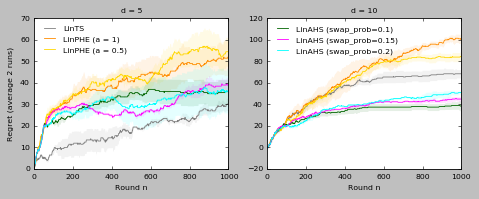

In [3]:
import datetime

reward_noise = "bernoulli"

algs = [
  #("LinUCB", {}, "cyan", "-", "LinUCB"),
  ("LinTS", {}, "gray", "-", "LinTS"),
  #("LinGreedy", {}, "blue", "-", "$\\varepsilon$-greedy"),
  #("LinPHE", {"a": 2}, "red", "-", "LinPHE (a = 2)"),
  ("LinPHE", {"a": 1}, "darkorange", "-", "LinPHE (a = 1)"),
  ("LinPHE", {"a": 0.5}, "gold", "-", "LinPHE (a = 0.5)"),
  #("LinAllHistorySwap", {"swap_prob": 0.05}, "cyan", "-", "LinFHS (swap_prob=0.05)"),
  ("LinHistorySwap", {"swap_prob": 0.1}, "darkgreen", "-", "LinAHS (swap_prob=0.1)"),
  ("LinHistorySwap", {"swap_prob": 0.15}, "magenta", "-", "LinAHS (swap_prob=0.15)"),
  ("LinHistorySwap", {"swap_prob": 0.2}, "cyan", "-", "LinAHS (swap_prob=0.2)"),
]
num_runs = 2
n = 1000
K = 50

step = np.arange(1, n + 1)
sube = (step.size // 10) * np.arange(1, 11) - 1

plt.figure(figsize=(6, 2.5))
for fig in range(2):
  if fig == 0:
    d = 5
  elif fig == 1:
    d = 10
  else:
    d = 20

  env = []
  for run in range(num_runs):
    # standard d-dimensional basis (with a bias term)
    basis = np.eye(d)
    basis[:, -1] = 1

    # arm features in a unit (d - 2)-sphere
    X = np.random.randn(K, d - 1)
    X /= np.sqrt(np.square(X).sum(axis=1))[:, np.newaxis]
    X = np.hstack((X, np.ones((K, 1))))  # bias term
    X[: basis.shape[0], :] = basis

    # parameter vector in a (d - 2)-sphere with radius 0.5
    theta = np.random.randn(d - 1)
    theta *= 0.5 / np.sqrt(np.square(theta).sum())
    theta = np.append(theta, [0.5])

    # create environment
    env.append(LinBandit(X, theta, reward_noise))
    print("%3d: %.2f %.2f | " % (env[-1].best_arm,
      env[-1].mu.min(), env[-1].mu.max()), end="")
    if (run + 1) % 10 == 0:
      print()

  plt.subplot(1, 2, fig + 1)
  # plt.subplot(1, 1, 1)
  alg_num = 0
  for alg in algs:
    alg_class = eval(alg[0])

#     fname = "%s/lin_d=%d_%d_%s.npy" % \
#       (current_dir, d, alg_num, alg[0].lower())
#     if not os.path.exists(fname):
#       regret, _ = evaluate(alg_class, alg[1], env, n)
#       with open(fname, "wb") as f:
#         np.save(f, regret)
#     with open(fname, "rb") as f:
#       regret = np.load(f)
    if d < 14:
        regret, _ = evaluate_parallel(alg_class, alg[1], env, n, num_process=10)
    else:
        regret, _ = evaluate(alg_class, alg[1], env, n)

    cum_regret = regret.cumsum(axis=0)
    std_regret = cum_regret.std(axis=1) / np.sqrt(cum_regret.shape[1])
    plt.plot(step, cum_regret.mean(axis=1),
      alg[2], dashes=linestyle2dashes(alg[3]),
      label=alg[4] if alg_num // 3 == fig else None)
    plt.fill_between(step,
      cum_regret.mean(axis=1) - std_regret,
      cum_regret.mean(axis=1) + std_regret,
      color=alg[2], alpha=0.1, linewidth=0)

    alg_num += 1

  plt.title("d = %d" % d)
  plt.xlabel("Round n")
  if not fig:
    plt.ylabel("Regret (average {} runs)".format(num_runs))
  #plt.ylim(0, 500 - 100 * (2 - fig))
  if fig <= 1:
    plt.legend(loc="upper left", frameon=False)

plt.tight_layout()

now = datetime.datetime.now()
with open("../results/LinHS_{}_{}_{}_{}_{}.jpeg".format(reward_noise, now.month, now.day, now.hour, now.minute), "wb") as f:
  plt.savefig(f, format="jpeg", dpi=1200, bbox_inches=0)
plt.show()